<a href="https://colab.research.google.com/github/filnels/Homeworks/blob/main/Clustering_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,  roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import  roc_auc_score

from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay)
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# прочитаем файл
cr_data = pd.read_csv('SouthGermanCredit.asc', sep=r'\s+', engine='python')

print(cr_data.head())


   laufkont  laufzeit  moral  verw  hoehe  sparkont  beszeit  rate  famges  \
0         1        18      4     2   1049         1        2     4       2   
1         1         9      4     0   2799         1        3     2       3   
2         2        12      2     9    841         2        4     2       2   
3         1        12      4     0   2122         1        3     3       3   
4         1        12      4     0   2171         1        3     4       3   

   buerge  ...  verm  alter  weitkred  wohn  bishkred  beruf  pers  telef  \
0       1  ...     2     21         3     1         1      3     2      1   
1       1  ...     1     36         3     1         2      3     1      1   
2       1  ...     1     23         3     1         1      2     2      1   
3       1  ...     1     39         3     1         2      2     1      1   
4       1  ...     2     38         1     2         2      2     2      1   

   gastarb  kredit  
0        2       1  
1        2       1  
2    

In [ ]:
#так как многие наши категориальные признаки, не порядковые, чтоб учитывать важность каждого признака, применим
#One_Hot_Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Применяем OneHotEncoding для категориальных признаков
categorical_columns = ['laufkont', 'moral', 'verw', 'sparkont', 'famges', 'buerge', 'weitkred', 'wohn']
cr_data = pd.get_dummies(cr_data, columns=categorical_columns, drop_first=True)


# Применяем Ordinal Encoding для порядковых признаков
ordinal_columns = ['beszeit', 'rate', 'wohnzeit', 'verm', 'bishkred', 'beruf']
# Инициализируем OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
# Применяем кодирование к порядковым признакам
cr_data[ordinal_columns] = ordinal_encoder.fit_transform(cr_data[ordinal_columns])

# Перевод бинарных признаков из "1" и "2" в 0 и 1
binary_columns = ['pers', 'telef', 'gastarb']

for col in binary_columns:
    cr_data[col] = cr_data[col].apply(lambda x: 1 if x == 2 else 0)




In [ ]:
cr_data.head()

,laufzeit,hoehe,beszeit,rate,wohnzeit,verm,alter,bishkred,beruf,pers,...,sparkont_5,famges_2,famges_3,famges_4,buerge_2,buerge_3,weitkred_2,weitkred_3,wohn_2,wohn_3
0,18,1049,1.0,3.0,3.0,1.0,21,0.0,2.0,1,...,False,True,False,False,False,False,False,True,False,False
1,9,2799,2.0,1.0,1.0,0.0,36,1.0,2.0,0,...,False,False,True,False,False,False,False,True,False,False
2,12,841,3.0,1.0,3.0,0.0,23,0.0,1.0,1,...,False,True,False,False,False,False,False,True,False,False
3,12,2122,2.0,2.0,1.0,0.0,39,1.0,1.0,0,...,False,False,True,False,False,False,False,True,False,False
4,12,2171,2.0,3.0,3.0,1.0,38,1.0,1.0,1,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import pairwise_distances


quant_features = ['hoehe', 'alter']  # Количественные признаки для масштабирования
scaler = StandardScaler()
cr_data[quant_features] = scaler.fit_transform(cr_data[quant_features])

# Применяем t-SNE для уменьшения размерности до 2
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(cr_data)

# Функция для вычисления метрики D (среднее расстояние между центроидами кластеров)
def compute_centroid_distances(cluster_centers):
    distances = pairwise_distances(cluster_centers)
    np.fill_diagonal(distances, np.nan)  # Убираем расстояние до себя
    return np.nanmean(distances)  # Среднее расстояние между центроидами кластеров


# Применяем метод k-means для кластеризации
results = []
# Перебираем количество кластеров от 2 до 6
for clusters in range(2, 6):
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    labels = kmeans.fit_predict(data_tsne)
    cluster_centers = kmeans.cluster_centers_

    # Оценка кластеризации с использованием различных метрик
    centroid_distances = compute_centroid_distances(cluster_centers)
    silhouette_avg = silhouette_score(data_tsne, labels)
    davies_bouldin = davies_bouldin_score(data_tsne, labels)
    calinski_harabasz = calinski_harabasz_score(data_tsne, labels)
    homogeneity = homogeneity_score(cr_data['kredit'], labels)
    completeness = completeness_score(cr_data['kredit'], labels)
    v_measure = v_measure_score(cr_data['kredit'], labels)

    # Сохраняем результаты
    results.append({
        'clusters': clusters,
        'Silhouette': silhouette_avg,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski_harabasz,
        'D (Centroid Distances)': centroid_distances,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    })

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz  \
0         2    0.541644        0.651426        1746.795409   
1         3    0.521078        0.766875        1488.735171   
2         4    0.621889        0.548009        2841.872707   
3         5    0.613552        0.504648        2462.752709   

   D (Centroid Distances)  Homogeneity  Completeness  V-Measure  
0               56.939152     0.025523      0.022798   0.024084  
1               49.680256     0.029439      0.017089   0.021625  
2               51.121643     0.032842      0.014878   0.020478  
3               50.821484     0.035700      0.014868   0.020993  


In [ ]:
#видим значительное улучшение наших метрик, но к сожалению, модель все еще неправильно распределяет в кластере, близки к нулю наши показатели
#Homogenity, Completeness, V-Measure

In [ ]:
  # Используем K-Means++
results = []
# Перебираем количество кластеров от 2 до 6
for clusters in range(2, 6):
    kmeans_plus = KMeans(n_clusters=clusters, init='k-means++', random_state=42)
    kmeans_plus.fit(cr_data)
    labels_plus = kmeans_plus.labels_
    cluster_centers = kmeans_plus.cluster_centers_

     # Оценка кластеризации с использованием различных метрик

    centroid_distances = compute_centroid_distances(cluster_centers)
    silhouette_avg = silhouette_score(data_tsne, labels)
    davies_bouldin = davies_bouldin_score(data_tsne, labels)
    calinski_harabasz = calinski_harabasz_score(data_tsne, labels)
    homogeneity = homogeneity_score(cr_data['kredit'], labels)
    completeness = completeness_score(cr_data['kredit'], labels)
    v_measure = v_measure_score(cr_data['kredit'], labels)

 # Сохраняем результаты
    results.append({
        'clusters': clusters,
        'Silhouette': silhouette_avg,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski_harabasz,
        'D (Centroid Distances)': centroid_distances,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    })


# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)
print(results_df)


   clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz  \
0         2    0.613552        0.504648        2462.752709   
1         3    0.613552        0.504648        2462.752709   
2         4    0.613552        0.504648        2462.752709   
3         5    0.613552        0.504648        2462.752709   

   D (Centroid Distances)  Homogeneity  Completeness  V-Measure  
0               24.196325       0.0357      0.014868   0.020993  
1               25.347279       0.0357      0.014868   0.020993  
2               22.111832       0.0357      0.014868   0.020993  
3               21.743583       0.0357      0.014868   0.020993  


In [ ]:
#данный метод показал, что для разных количества  кластеров одинаковые значения метрик

In [ ]:
#применим Elbow Method for Optimal Clusters

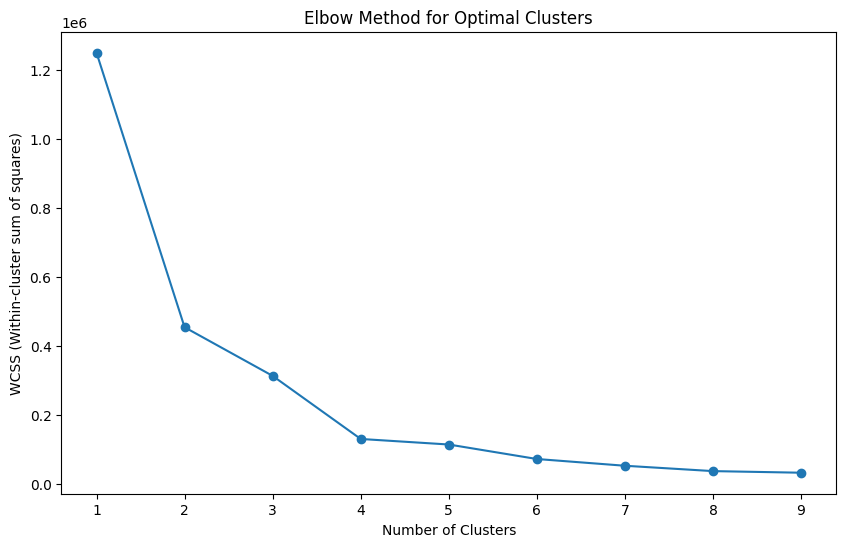

In [ ]:
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_tsne)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.show()



In [ ]:
# также оптимальное количество 4 кластера

In [ ]:
 #методом K-Means: для 4 кластеров (выбрано на основе результатов метрик и метода локтя)

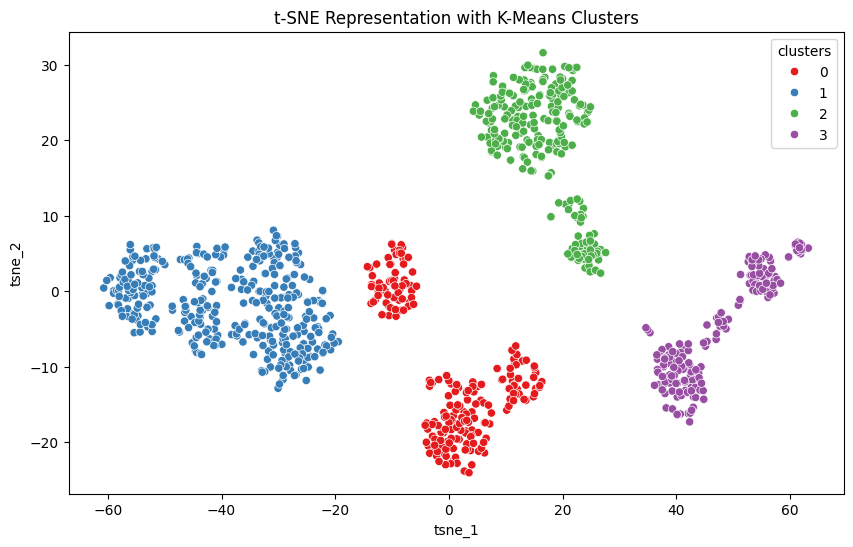

In [ ]:
# Преобразуем данные t-SNE в отдельные столбцы DataFrame
cr_data['tsne_1'] = data_tsne[:, 0]
cr_data['tsne_2'] = data_tsne[:, 1]

# Применяем K-Means с оптимальным количеством кластеров
optimal_clusters = 4  # оптимальное количество кластеров на основе анализа
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cr_data['clusters'] = kmeans.fit_predict(data_tsne)

# Визуализируем результаты с помощью t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='clusters', data=cr_data, palette='Set1')
plt.title('t-SNE Representation with K-Means Clusters')
plt.show()


In [ ]:
# сейчас Видим, что кластеры очень хорошо отделены друг от друга, а также местами плотнее расположены точки внутри кластера.

In [ ]:
#попробуем применить алгомеративный метод:

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Применяем агломеративную кластеризацию для кластеризации
results = []
# Перебираем количество кластеров от 2 до 6
for clusters in range(2, 6):
    agglomerative = AgglomerativeClustering(n_clusters=clusters)
    labels = agglomerative.fit_predict(data_tsne)


    # Оценка кластеризации с использованием различных метрик
    silhouette_avg = silhouette_score(data_tsne, labels)
    davies_bouldin = davies_bouldin_score(data_tsne, labels)
    calinski_harabasz = calinski_harabasz_score(data_tsne, labels)
    homogeneity = homogeneity_score(cr_data['kredit'], labels)
    completeness = completeness_score(cr_data['kredit'], labels)
    v_measure = v_measure_score(cr_data['kredit'], labels)

    # Сохраняем результаты
    results.append({
        'clusters': clusters,
        'Silhouette': silhouette_avg,
        'Davies-Bouldin': davies_bouldin,
        'Calinski-Harabasz': calinski_harabasz,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    })

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz  Homogeneity  \
0         2    0.541644        0.651426        1746.795409     0.025523   
1         3    0.525144        0.770783        1654.640150     0.035943   
2         4    0.607926        0.481746        2339.052341     0.036189   
3         5    0.596029        0.553223        3241.059659     0.039207   

   Completeness  V-Measure  
0      0.022798   0.024084  
1      0.021254   0.026713  
2      0.017042   0.023172  
3      0.015107   0.021810  


In [ ]:
#видим, что данный метод хуже работает

In [ ]:
import hdbscan

# Применяем HDBSCAN для кластеризации
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2)
labels = hdbscan_model.fit_predict(data_tsne)


# Оценка кластеризации с использованием различных метрик

silhouette_avg = silhouette_score(data_tsne, labels)
davies_bouldin = davies_bouldin_score(data_tsne, labels)
calinski_harabasz = calinski_harabasz_score(data_tsne, labels)
homogeneity = homogeneity_score(cr_data['kredit'], labels)
completeness = completeness_score(cr_data['kredit'], labels)
v_measure = v_measure_score(cr_data['kredit'], labels)

# Сохраняем результаты
results = {
    'Silhouette': silhouette_avg,
    'Davies-Bouldin': davies_bouldin,
    'Calinski-Harabasz': calinski_harabasz,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure
}

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame([results])
print(results_df)

   Silhouette  Davies-Bouldin  Calinski-Harabasz  Homogeneity  Completeness  \
0     0.25811         1.21803          61.451611     0.239999      0.036123   

   V-Measure  
0   0.062794  


In [ ]:
#Выводы: таким образом применение различных методов кластеризации показало не самые лучшие результаты
#на этом датасете.Немного улучшило результаты удаление одного коррелируемого признака. важно провести детальный анализ данных,
#с фичиинжинирингом, чтоб улучшить кластеризацию. Целью данной работы было изучить как работают различные методы кластеризации и оценить метрики.